In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import ipaddress
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
from sklearn.metrics import f1_score
# import kerastuner as kt
# import IPython
import joblib
from sklearn.metrics import classification_report

In [2]:
def to_int(x):
    return int(x, 16)

In [3]:
path = "./datasets/iot-network-intrusion-dataset_190919/Packets_integrated/"

# 파일 변환 코드

In [4]:
# # names_list = [f for f in os.listdir(path) if f.endswith('.txt')]
# # for txt in names_list:
#     packet = pd.read_csv(os.path.join(path, txt), sep="\n", header = None)
#     packet[packet[0].str.contains("Frame \(")] = "\f"
#     packet[0] = packet[0].str[:53]
#     packet = packet[0].str.split("  ", expand=True)
#     packet = packet[[0, 1]]
#     packet = pd.DataFrame(packet.to_string(header=None, index=False).split("\f"))
#     print("Almost Done!")
#     packet[0]=packet[0].str.lstrip()
#     packet[0] = packet[0].str.replace("\n", " ")
#     for _ in range(10):
#         packet[0] = packet[0].str.replace("  ", " ")
#     packet[0] = packet[0].str[:222]
#     packet = packet[0].str.split(" ", expand=True)
#     packet=packet.fillna("00")
#     packet = packet.drop(columns=[0, 17, 34, 51, 68, 71])
#     packet=packet.replace("","00")
#     packet.to_csv(os.path.join(path, txt).replace(".txt","_hex")+".csv")
#     print(txt,"done")
# #     packet = packet.applymap(to_int)

# Reading files

In [5]:
hex_list = [f for f in os.listdir(path) if f.endswith('hex.csv')]

In [6]:
hex_list

['benign-dec_hex.csv',
 'dos-synflooding_hex.csv',
 'mirai-ackflooding_hex.csv',
 'mirai-hostbruteforce-1,3,5_hex.csv',
 'mirai-hostbruteforce-2,4_hex.csv',
 'mirai-httpflooding_hex.csv',
 'mirai-udpflooding_hex.csv',
 'mitm_hex.csv',
 'scan-hostport_1_hex.csv',
 'scan-hostport_2_hex.csv',
 'scan-hostport_3_hex.csv',
 'scan-hostport_4_hex.csv',
 'scan-hostport_5_hex.csv',
 'scan-hostport_6_hex.csv',
 'scan-portos_hex.csv']

In [7]:
dict_names=hex_list.copy()
csv_list=hex_list.copy()
for i in range(len(hex_list)):
    dict_names[i] = hex_list[i].replace("_hex.csv","")
    csv_list[i] = hex_list[i].replace("_hex","")

In [8]:
dict_names

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce-1,3,5',
 'mirai-hostbruteforce-2,4',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-hostport_1',
 'scan-hostport_2',
 'scan-hostport_3',
 'scan-hostport_4',
 'scan-hostport_5',
 'scan-hostport_6',
 'scan-portos']

In [9]:
csv_list

['benign-dec.csv',
 'dos-synflooding.csv',
 'mirai-ackflooding.csv',
 'mirai-hostbruteforce-1,3,5.csv',
 'mirai-hostbruteforce-2,4.csv',
 'mirai-httpflooding.csv',
 'mirai-udpflooding.csv',
 'mitm.csv',
 'scan-hostport_1.csv',
 'scan-hostport_2.csv',
 'scan-hostport_3.csv',
 'scan-hostport_4.csv',
 'scan-hostport_5.csv',
 'scan-hostport_6.csv',
 'scan-portos.csv']

In [10]:
X_dict = {}
for i, packets in enumerate(hex_list):
    X_dict[dict_names[i]] = pd.read_csv(os.path.join(path, packets),index_col=0, dtype=str)
    X_dict[dict_names[i]] = X_dict[dict_names[i]].join(pd.read_csv(os.path.join(path,csv_list[i])),how="outer")

X_dict['mirai-hostbruteforce-1,3,5'] 이런 이름의 사전형으로 데이터프레임을 분류하였다

In [11]:
y_dict = {}
for key, value in enumerate(X_dict):
    y_dict[value] = pd.read_csv(os.path.join(path, value)+"_attacked.csv", header=None)[0][1:].apply(int)

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
for i in dict_names:
    print(i, len(X_dict[i]),"    attacked", len(y_dict[i]))

benign-dec 137396     attacked 0
dos-synflooding 141709     attacked 64646
mirai-ackflooding 313462     attacked 75632
mirai-hostbruteforce-1,3,5 273357     attacked 1636
mirai-hostbruteforce-2,4 179998     attacked 961
mirai-httpflooding 248294     attacked 10464
mirai-udpflooding 1187114     attacked 949284
mitm 194184     attacked 101885
scan-hostport_1 29352     attacked 1490
scan-hostport_2 37106     attacked 2701
scan-hostport_3 13555     attacked 1730
scan-hostport_4 7801     attacked 1707
scan-hostport_5 4760     attacked 2211
scan-hostport_6 6828     attacked 2401
scan-portos 211078     attacked 12970


# 4번째 줄의 i를 바꿔서 다변량 or 이중 분류에 맞는 라벨 값 생성할 것

세부 카테고리에 맞추어 공격을 순서대로 0~9의 값으로 만들어 라벨을 생성하였다.

In [13]:
label_dict={}
for i,k in enumerate(dict_names):
    label = np.zeros(len(X_dict[k]))
    label[y_dict[k]-1] = i
    label_dict[k] = label

In [14]:
label_dict["mirai-hostbruteforce-2,4"][label_dict["mirai-hostbruteforce-2,4"]==4]=3
label_dict["scan-hostport_1"][label_dict["scan-hostport_1"]==8]=4
label_dict["scan-hostport_2"][label_dict["scan-hostport_2"]==9]=4
label_dict["scan-hostport_3"][label_dict["scan-hostport_3"]==10]=4
label_dict["scan-hostport_4"][label_dict["scan-hostport_4"]==11]=4
label_dict["scan-hostport_5"][label_dict["scan-hostport_5"]==12]=4
label_dict["scan-hostport_6"][label_dict["scan-hostport_6"]==13]=4
label_dict["scan-portos"][label_dict["scan-portos"]==14]=8

In [15]:
binary_label_dict={}
for i,k in enumerate(dict_names):
    label = np.zeros(len(X_dict[k]))
    label[y_dict[k]-1] = 1
    ###               이부분에 i가 아닌 1이 붙었으므로 이 라벨값 사용시 이중분류기가 됨
    binary_label_dict[k] = label

In [16]:
X_reduced = {}
for i in X_dict.keys():
    X_dict[i]["SourcePort"] = (X_dict[i]["37"]+X_dict[i]["38"]).apply(to_int)
    X_dict[i]["DestinationPort"] = (X_dict[i]["39"]+X_dict[i]["40"]).apply(to_int)
    X_reduced[i] = pd.DataFrame()
    X_reduced[i]["SourcePort"] = X_dict[i]["SourcePort"]    
    X_reduced[i]["DestinationPort"] = X_dict[i]["DestinationPort"]
    X_reduced[i]["Source"] = X_dict[i]["Source"]        
    X_reduced[i]["Destination"] = X_dict[i]["Destination"]
    X_reduced[i]["Time"] = X_dict[i]["Time"]  
    X_reduced[i]["Protocol"] = X_dict[i]["Protocol"]            
    X_reduced[i]["Length"] = X_dict[i]["Length"]            

# Protocol역시 리벨 인코딩을 통해 추가
# Length역시 넣다 빼고 결과 보기

## 아래에서 원하는 공격의 인덱스를 넣어 데이터를 분류할것

In [17]:
for i,k in enumerate(dict_names):
    print(i, k)

0 benign-dec
1 dos-synflooding
2 mirai-ackflooding
3 mirai-hostbruteforce-1,3,5
4 mirai-hostbruteforce-2,4
5 mirai-httpflooding
6 mirai-udpflooding
7 mitm
8 scan-hostport_1
9 scan-hostport_2
10 scan-hostport_3
11 scan-hostport_4
12 scan-hostport_5
13 scan-hostport_6
14 scan-portos


In [18]:
flooding_list=[dict_names[0],dict_names[1], dict_names[2], dict_names[5], dict_names[6]]

In [19]:
all_list=["benign-dec", "dos-synflooding", "mirai-ackflooding", "mirai-hostbruteforce", "scan-hostport",
         "mirai-httpflooding", "mirai-udpflooding","mitm","scan-portos"]

In [20]:
def make_X(target_list):    
    X=pd.DataFrame([])
    for i in target_list:
        X = X.append(X_reduced[i], ignore_index=True)
    return X

In [21]:
dict_names

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce-1,3,5',
 'mirai-hostbruteforce-2,4',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-hostport_1',
 'scan-hostport_2',
 'scan-hostport_3',
 'scan-hostport_4',
 'scan-hostport_5',
 'scan-hostport_6',
 'scan-portos']

In [22]:
def make_y(target_list, label):
    y=[]
    for i in target_list:
        y.extend(label[i])
################ label_dict대신 binary_label_dict 사용시 이중분류를 위한 라벨값 생성가능
    y = np.array(y)
    return y

In [23]:
X = make_X(dict_names)
y = make_y(dict_names, label_dict)
### label_dict와 binary_label_dict를 넣어주면 된다

In [24]:
pd.Series(y).value_counts()

0.0    1756276
6.0     949284
7.0     101885
2.0      75632
1.0      64646
8.0      12970
4.0      12240
5.0      10464
3.0       2597
dtype: int64

In [25]:
encoder = LabelEncoder()
encoder.fit(X["Source"].append(X["Destination"]))
X["Source"] = encoder.transform(X["Source"])
X["Destination"] = encoder.transform(X["Destination"])
encoder = LabelEncoder()
X["Protocol"] = encoder.fit_transform(X["Protocol"])


###  공격을 쪼개서 따로 사전에 보관하는 코드
### 병렬적으로 학습시킨 후 예측하는 모델의 정확도가 낮으므로 현재는 주석처리

In [26]:
# X_flooding={}
# y_flooding={}
# for i in flooding_list:
#     X_flooding[i] = X_reduced[i]
#     y_flooding[i] = label_dict[i]

In [27]:
# scaler = StandardScaler()
# X_flooding_scaled = {}
# for i in X_flooding:
#     X_flooding[i]["Source"] = encoder.transform(X_flooding[i]["Source"])
#     X_flooding[i]["Destination"] = encoder.transform(X_flooding[i]["Destination"])
#     X_flooding_scaled[i] = scaler.fit_transform(X_flooding[i])

In [28]:
print("X shape:", X.shape, "    attacked y len:",len(y[y!=0]),"\n")
for i,k in enumerate(dict_names):
    if i==0:
        print(k, "num:", len(y[y==i]))
    else:
        print(k,"attack num:", len(y[y==i]))

### 공격을 뭉쳐주면서 인덱스가 조금 수정됨 모든 공격에 대한 패킷 수 chk'는 끝났으므로 검토 필요 x

X shape: (2985994, 7)     attacked y len: 1229718 

benign-dec num: 1756276
dos-synflooding attack num: 64646
mirai-ackflooding attack num: 75632
mirai-hostbruteforce-1,3,5 attack num: 2597
mirai-hostbruteforce-2,4 attack num: 12240
mirai-httpflooding attack num: 10464
mirai-udpflooding attack num: 949284
mitm attack num: 101885
scan-hostport_1 attack num: 12970
scan-hostport_2 attack num: 0
scan-hostport_3 attack num: 0
scan-hostport_4 attack num: 0
scan-hostport_5 attack num: 0
scan-hostport_6 attack num: 0
scan-portos attack num: 0


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [30]:
X_train_10, X_valid_10, y_train_10, y_valid_10 = train_test_split(X,y, test_size=0.90, stratify=y)

In [31]:
X_train_10_scaled, X_valid_10_scaled= X_train_10, X_valid_10

In [32]:
scaler = StandardScaler()
X_train_10_scaled, X_valid_10_scaled = scaler.fit_transform(X_train_10_scaled), scaler.fit_transform(X_valid_10_scaled)

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25)

In [34]:
X_train_scaled, X_valid_scaled= X_train, X_valid

In [35]:
scaler = StandardScaler()
X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train_scaled), scaler.fit_transform(X_valid_scaled)

In [36]:
all_list

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce',
 'scan-hostport',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-portos']

In [37]:
# labels = ["benign", "attacked"]
labels = all_list

# 모델 학습시간 및 confusion matrix

## 주의!!
모델별 튜닝 파라미터<br>
logistic -> max_iter<br>
SVC -> max_iter<br>
KNN -> n_neighbor<br>
RF -> 없음

micro와 weighted는 각각 모든 샘플에 대한 f_1score와 클래스 각각에 대한 f_1score를 구한뒤에 클래스별로 가중치를 두어 평균낸 값이다

SVC는 LinearSVC보다 시간이 약 몇만배단위로 많이 걸리며 정확도는 오히려 낮다

파라미터별 모델 학습 시간  
logistic_500, 1000, 3000, 5000, 10000 = [627.9586172103882, 1227.1173121929169, 3619.7272477149963, 5690.838112831116, 11313.030550956726] <br>
svc_500, 1000, 3000 = [824.8870325088501, 1594.2300989627838, 4773.387805700302] -> scaled되지 않아서 성능 낮음<br>
libnear_svc_5000, 10000 = [6899.107973575592, 12329.086981773376]<br>
KNN_5, 10, 15 = [9786.591916561127, 9820.885631084442, 9798.824233531952]<br>
svc_scaled500, 1000, 3000 = [614.0165631771088, 1173.9415192604065, 25065.65817117691]

로지스틱과 RF만 스케일링 없이 학습시켰음을 참고

Logistic: [1334.7300844192505, 4033.4358859062195, 6716.488691568375]  
Linear: [1837.6272234916687, 4877.016712427139, 7248.260677099228]  
KNN: [9908.260229825974, 9806.591094017029, 10012.014149904251]

## model, max_iter자동화

In [38]:
model_list=[]
models = [file for file in os.listdir("./") if file.endswith("pkl") and "_" not in file]
for model in models:
    model_list.append(joblib.load("./" + model))

랜포는 오래 걸리지 않으니 대강 그래프 그리고 마무리하자

In [39]:
KNN_list = model_list[0]
Linear_list = model_list[1]
Logistic_list = model_list[2]

##  Linear_SCV confusion matrix

In [42]:
Linear_list

[LinearSVC(), LinearSVC(max_iter=3000), LinearSVC(max_iter=5000)]

In [64]:
y_pred = Linear_list[0].predict(X_valid_scaled)

In [57]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.89      0.96      0.92    439381
     dos-synflooding       0.00      0.00      0.00     16176
   mirai-ackflooding       0.80      0.84      0.82     18853
mirai-hostbruteforce       0.00      0.00      0.00       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.95      1.00      0.97    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.90    746499
           macro avg       0.29      0.31      0.30    746499
        weighted avg       0.84      0.90      0.87    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
y_pred = Linear_list[1].predict(X_valid_scaled)

In [52]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.89      0.96      0.92    439381
     dos-synflooding       0.00      0.00      0.00     16176
   mirai-ackflooding       0.80      0.84      0.82     18853
mirai-hostbruteforce       0.00      0.00      0.00       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.95      1.00      0.97    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.90    746499
           macro avg       0.29      0.31      0.30    746499
        weighted avg       0.84      0.90      0.87    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
y_pred = Linear_list[2].predict(X_valid_scaled)

In [55]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.89      0.96      0.92    439381
     dos-synflooding       0.00      0.00      0.00     16176
   mirai-ackflooding       0.80      0.84      0.82     18853
mirai-hostbruteforce       0.00      0.00      0.00       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.95      1.00      0.97    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.90    746499
           macro avg       0.29      0.31      0.30    746499
        weighted avg       0.84      0.90      0.87    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN confusion matrix

In [128]:
KNN_list

[KNeighborsClassifier(n_jobs=-1, n_neighbors=3),
 KNeighborsClassifier(n_jobs=-1),
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)]

In [78]:
y_pred = KNN_list[0].predict(X_valid_scaled)

In [79]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       0.97      0.99      0.98    439381
     dos-synflooding       1.00      1.00      1.00     16176
   mirai-ackflooding       1.00      1.00      1.00     18853
mirai-hostbruteforce       1.00      0.74      0.85       660
       scan-hostport       0.99      0.81      0.89      3098
  mirai-httpflooding       1.00      0.94      0.97      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       0.74      0.60      0.66     25301
         scan-portos       0.99      0.99      0.99      3181

            accuracy                           0.98    746499
           macro avg       0.97      0.90      0.93    746499
        weighted avg       0.98      0.98      0.98    746499



In [81]:
y_pred = KNN_list[1].predict(X_valid_scaled)

In [82]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       0.98      0.99      0.98    439381
     dos-synflooding       1.00      1.00      1.00     16176
   mirai-ackflooding       1.00      1.00      1.00     18853
mirai-hostbruteforce       1.00      0.74      0.85       660
       scan-hostport       0.98      1.00      0.99      3098
  mirai-httpflooding       1.00      0.94      0.97      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       0.74      0.61      0.67     25301
         scan-portos       0.99      0.99      0.99      3181

            accuracy                           0.98    746499
           macro avg       0.97      0.92      0.94    746499
        weighted avg       0.98      0.98      0.98    746499



In [83]:
y_pred = KNN_list[2].predict(X_valid_scaled)

In [84]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       0.98      0.99      0.98    439381
     dos-synflooding       1.00      1.00      1.00     16176
   mirai-ackflooding       1.00      1.00      1.00     18853
mirai-hostbruteforce       1.00      0.74      0.85       660
       scan-hostport       0.97      0.99      0.98      3098
  mirai-httpflooding       1.00      0.94      0.97      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       0.76      0.60      0.67     25301
         scan-portos       0.99      0.97      0.98      3181

            accuracy                           0.98    746499
           macro avg       0.96      0.91      0.94    746499
        weighted avg       0.98      0.98      0.98    746499



## Logistic confusion matrix 

In [132]:
Logistic_list

[LogisticRegression(max_iter=1000, n_jobs=-1),
 LogisticRegression(max_iter=3000, n_jobs=-1),
 LogisticRegression(max_iter=5000, n_jobs=-1)]

In [85]:
y_pred = Logistic_list[0].predict(X_valid)

In [86]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.86      0.92      0.89    439381
     dos-synflooding       0.57      0.13      0.22     16176
   mirai-ackflooding       0.00      0.00      0.00     18853
mirai-hostbruteforce       0.55      0.51      0.53       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.86      0.98      0.92    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.86    746499
           macro avg       0.32      0.28      0.28    746499
        weighted avg       0.79      0.86      0.82    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
y_pred = Logistic_list[1].predict(X_valid)

In [88]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       0.86      0.93      0.90    439381
     dos-synflooding       0.44      0.04      0.08     16176
   mirai-ackflooding       0.86      0.11      0.20     18853
mirai-hostbruteforce       0.78      0.56      0.65       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.88      0.98      0.93    237217
                mitm       0.09      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.87    746499
           macro avg       0.43      0.29      0.31    746499
        weighted avg       0.82      0.87      0.83    746499



In [89]:
y_pred = Logistic_list[2].predict(X_valid)

In [90]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.87      0.93      0.90    439381
     dos-synflooding       0.12      0.04      0.06     16176
   mirai-ackflooding       0.95      0.37      0.54     18853
mirai-hostbruteforce       0.72      0.56      0.63       660
       scan-hostport       0.00      0.00      0.00      3098
  mirai-httpflooding       0.00      0.00      0.00      2632
   mirai-udpflooding       0.89      0.98      0.93    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       0.00      0.00      0.00      3181

            accuracy                           0.87    746499
           macro avg       0.39      0.32      0.34    746499
        weighted avg       0.82      0.87      0.84    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RandomForest confusion matrix

In [91]:
model_rf = RandomForestClassifier(max_depth=5)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [92]:
y_pred =model_rf.predict(X_valid)

In [93]:
print(classification_report(y_valid, y_pred, target_names=labels))

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

          benign-dec       0.92      1.00      0.96    439381
     dos-synflooding       1.00      0.75      0.86     16176
   mirai-ackflooding       0.93      1.00      0.96     18853
mirai-hostbruteforce       0.00      0.00      0.00       660
       scan-hostport       0.99      0.19      0.32      3098
  mirai-httpflooding       1.00      0.34      0.51      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       0.00      0.00      0.00     25301
         scan-portos       1.00      0.00      0.00      3181

            accuracy                           0.95    746499
           macro avg       0.76      0.48      0.51    746499
        weighted avg       0.92      0.95      0.93    746499



C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
model_rf = RandomForestClassifier(max_depth=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [95]:
y_pred =model_rf.predict(X_valid)

In [96]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       1.00      0.99      0.99    439381
     dos-synflooding       1.00      1.00      1.00     16176
   mirai-ackflooding       1.00      1.00      1.00     18853
mirai-hostbruteforce       0.98      1.00      0.99       660
       scan-hostport       1.00      0.99      1.00      3098
  mirai-httpflooding       1.00      1.00      1.00      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       0.87      0.95      0.91     25301
         scan-portos       1.00      0.97      0.98      3181

            accuracy                           0.99    746499
           macro avg       0.98      0.99      0.99    746499
        weighted avg       0.99      0.99      0.99    746499



In [97]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [98]:
y_pred =model_rf.predict(X_valid)

In [99]:
print(classification_report(y_valid, y_pred, target_names=labels))

                      precision    recall  f1-score   support

          benign-dec       1.00      1.00      1.00    439381
     dos-synflooding       1.00      1.00      1.00     16176
   mirai-ackflooding       1.00      1.00      1.00     18853
mirai-hostbruteforce       1.00      1.00      1.00       660
       scan-hostport       1.00      1.00      1.00      3098
  mirai-httpflooding       1.00      1.00      1.00      2632
   mirai-udpflooding       1.00      1.00      1.00    237217
                mitm       1.00      1.00      1.00     25301
         scan-portos       1.00      1.00      1.00      3181

            accuracy                           1.00    746499
           macro avg       1.00      1.00      1.00    746499
        weighted avg       1.00      1.00      1.00    746499



# Confusion matrix(논문 이미지용)

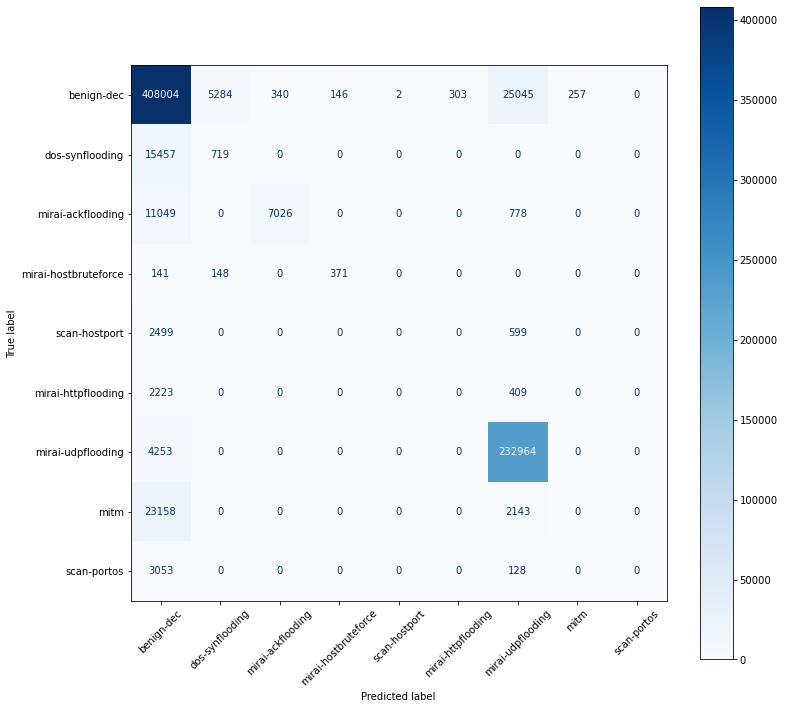

In [101]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('')
plot_confusion_matrix(Logistic_list[2], X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues,
                      ax=ax, xticks_rotation=45)

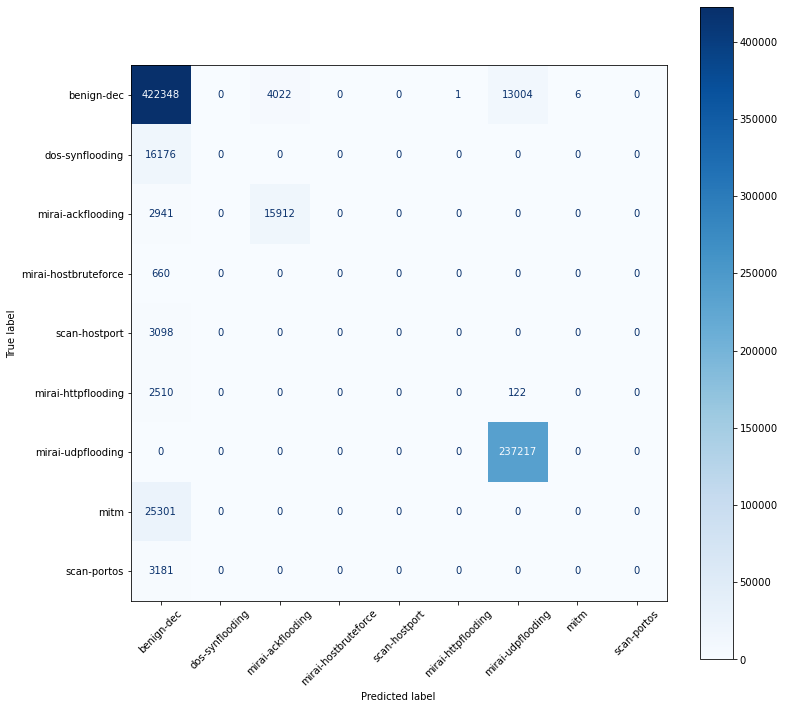

In [103]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('')
plot_confusion_matrix(Linear_list[2], X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues,
                      ax=ax, xticks_rotation=45)

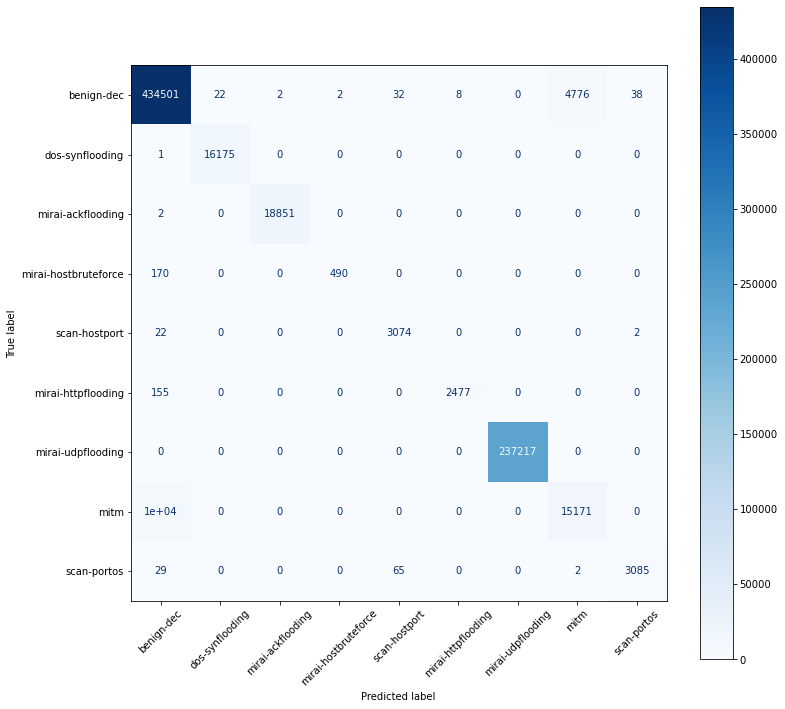

In [104]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('')
plot_confusion_matrix(KNN_list[2], X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues,
                      ax=ax, xticks_rotation=45)

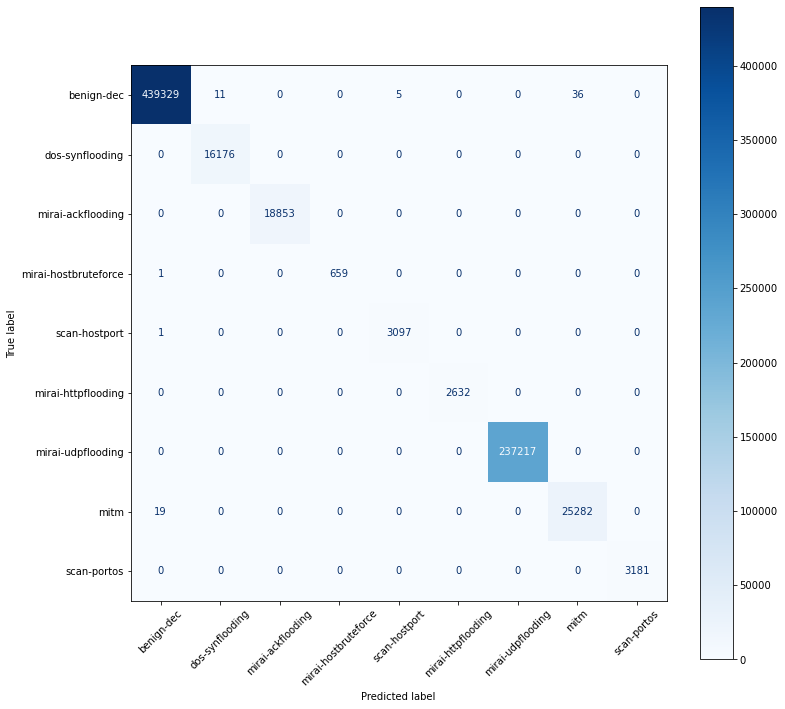

In [107]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('')
plot_confusion_matrix(model_rf, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues,
                      ax=ax, xticks_rotation=45)

In [106]:
fig, ax = plt.subplots(figsize=(12, 12))
model_logistic = LogisticRegression(max_iter=3000)
model_logistic.fit(X_train, y_train)
plot_confusion_matrix(model_logistic, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues,
                      ax=ax, xticks_rotation="vertical")


C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


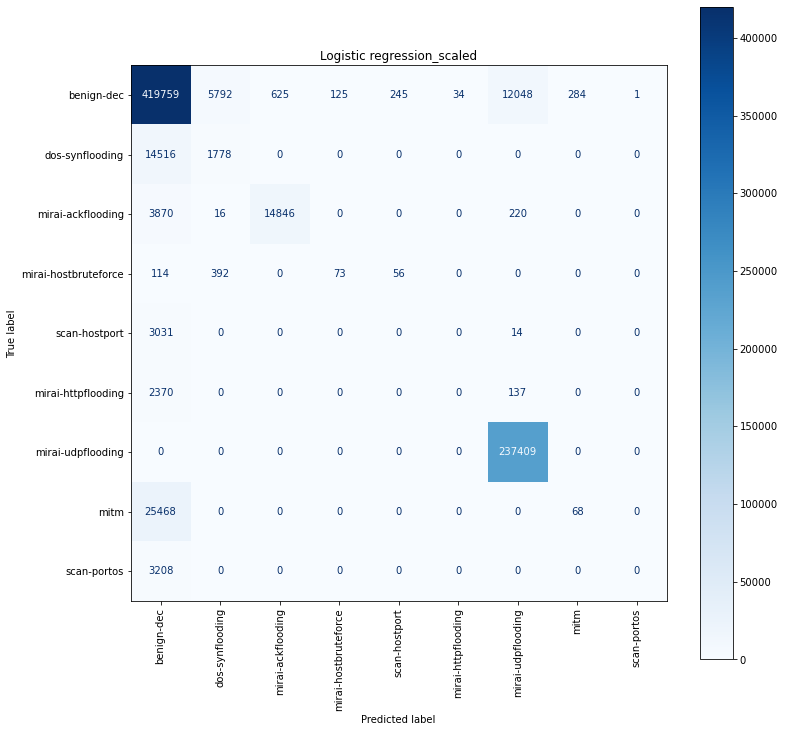

In [44]:
fig, ax = plt.subplots(figsize=(12, 12))
model_logistic = LogisticRegression(max_iter=50)
model_logistic.fit(X_train_scaled, y_train)
plt.title('Logistic regression_scaled')
plot_confusion_matrix(model_logistic, X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                      ax=ax, xticks_rotation="vertical")

# SVC

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


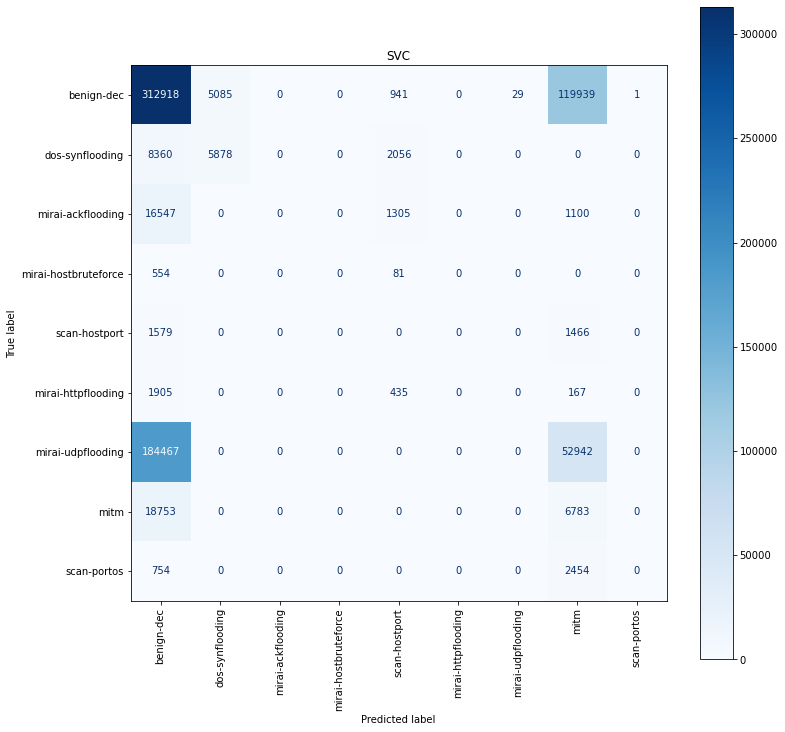

In [45]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = SVC(max_iter=1)
model_knn.fit(X_train, y_train)
plt.title('SVC')
plot = plot_confusion_matrix(model_knn, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                             ax=ax, xticks_rotation="vertical")

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


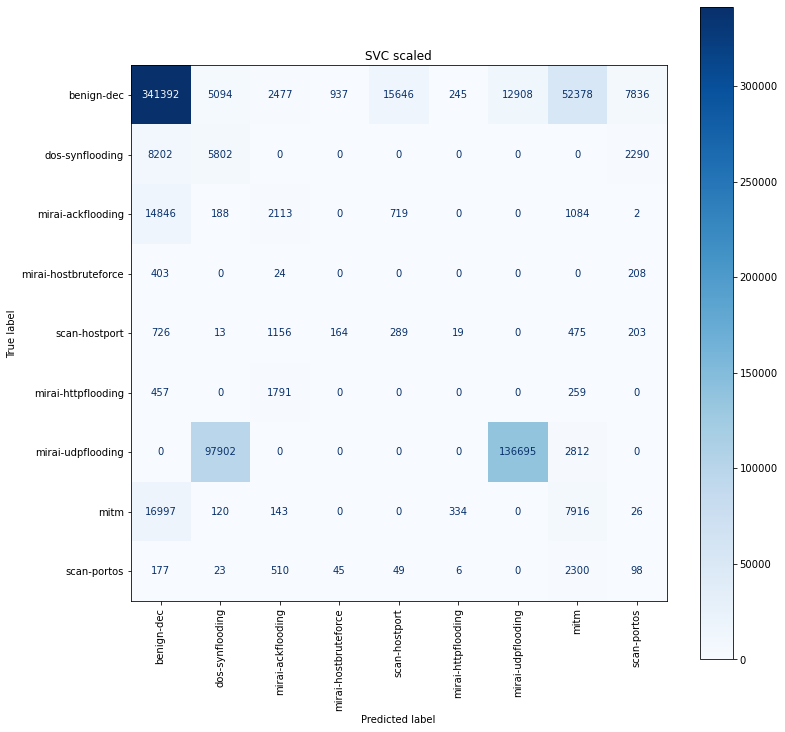

In [46]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = SVC(max_iter=1)
model_knn.fit(X_train_scaled, y_train)
plt.title('SVC scaled')
plot = plot_confusion_matrix(model_knn, X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                             ax=ax, xticks_rotation="vertical")

# KNN 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
plt.title('KNN')
plot = plot_confusion_matrix(model_knn, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                             ax=ax, xticks_rotation="vertical")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_scaled, y_train)
plt.title('KNN_scaled')
plot = plot_confusion_matrix(model_knn, X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                             ax=ax, xticks_rotation="vertical")

# RandomForest

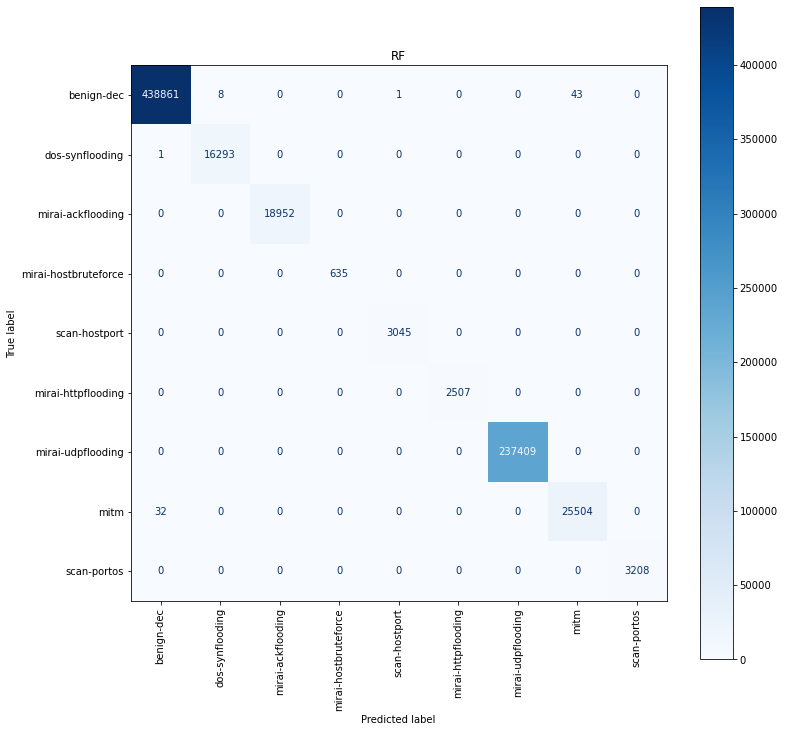

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
plt.title('RF')
plot = plot_confusion_matrix(model_rf, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues, 
                             ax=ax, xticks_rotation="vertical")

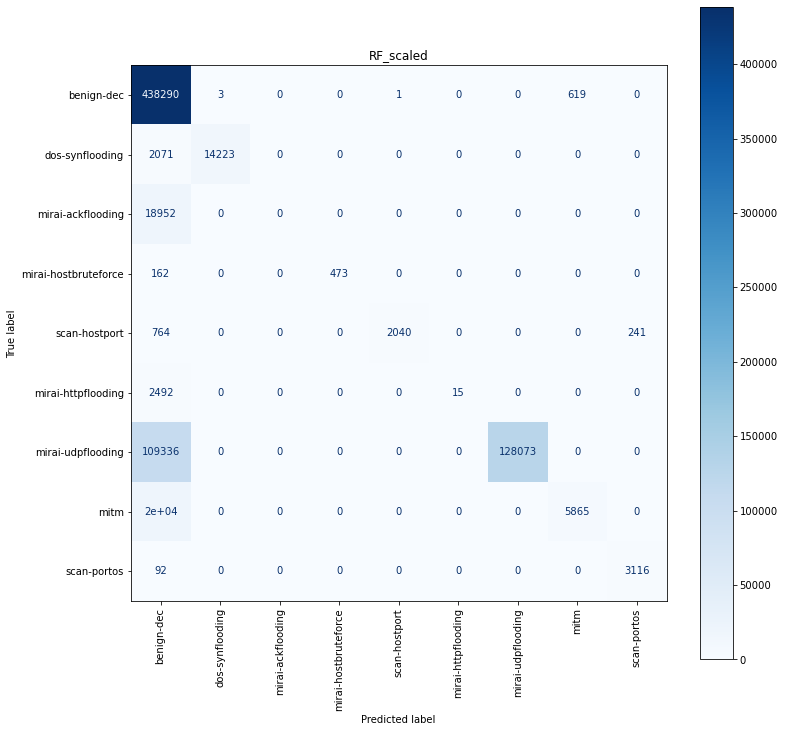

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)
plt.title('RF_scaled')
plot = plot_confusion_matrix(model_rf, X_valid_scaled, y_valid, display_labels=labels, cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

# 이곳에서 잠시 중단!

In [58]:
X

,SourcePort,DestinationPort,Source,Destination,Time,Protocol,Length
0,9020,49784,27906,27919,0.000000,579,1498
1,9020,49784,27906,27919,0.000144,579,140
2,9020,49784,27906,27919,0.000227,579,1502
3,9020,49784,27906,27919,0.000765,579,1498
4,9020,49784,27906,27919,0.000840,579,1502
...,...,...,...,...,...,...,...
2985989,41467,443,27952,63363,2271.383891,579,110
2985990,41467,443,27952,63363,2271.383976,579,114
2985991,41467,443,27952,63363,2271.384413,579,110
2985992,41467,443,27952,63363,2271.384490,579,114


In [56]:
model_rf.feature_importances_

array([0.2000174 , 0.13092149, 0.03406073, 0.21131727, 0.09400999,
       0.16448191, 0.1651912 ])

In [35]:
def create_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[X_train.shape[1]]))
    
    hp_units_1 = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    hp_units_2 = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
    
    model.add(keras.layers.Dense(units=hp_units_1, activation="relu"))
    model.add(keras.layers.Dense(units=hp_units_2, activation="relu"))

    model.add(keras.layers.Dense(9, activation="softmax"))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  metrics=["accuracy"])
    return model
# history = model.fit(X_train, y_train, epochs=1, validation_data = (X_valid, y_valid), batch_size=64)

In [36]:
tuner = kt.RandomSearch( create_model, # HyperModel
                    objective='val_accuracy', # 최적화할 하이퍼모델
                    max_trials=5,
                    executions_per_trial=3, # 각 모델별 학습 회수
                    directory='my_dir', # 사용된 parameter 저장할 폴더
                    project_name='intro_to_kt') # 사용된 parameter 저장할 폴더

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json


In [240]:
tuner = kt.Hyperband(create_model,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     factor = 5,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json


In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[X_train.shape[1]]))
model.add(keras.layers.Dense(units=5, activation="relu"))
model.add(keras.layers.Dense(units=5, activation="relu"))
model.add(keras.layers.Dense(9, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate = 0.001),metrics=["accuracy"])
    
model.fit(X_train, y_train, epochs=5, validation_data = (X_valid, y_valid), callbacks=[TqdmCallback(verbose=2)])    

NameError: name 'TqdmCallback' is not defined

In [101]:
model.history["acc"]

TypeError: 'History' object is not subscriptable

In [102]:
history["accuracy"]

TypeError: 'Sequential' object is not subscriptable

In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [40]:
print(best_hps.get("units"), best_hps.get("learning_rate"))

5 0.001


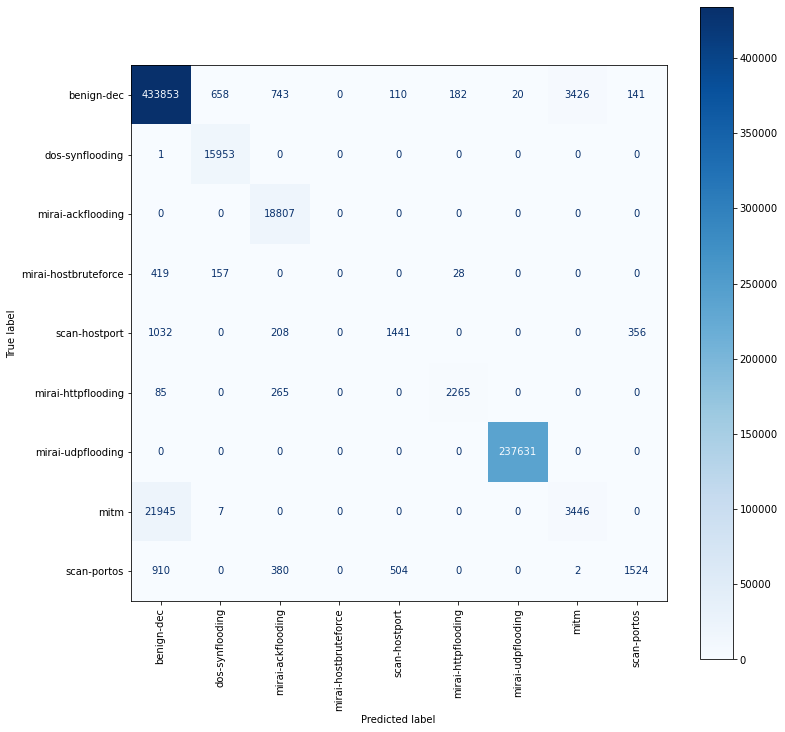

In [86]:
fig, ax = plt.subplots(figsize=(12, 12))
pred = model.predict_classes(X_valid)
cm=confusion_matrix(y_valid,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

In [ ]:
# hist_list = []
# # 노드개수 3개인것도 추가해주자
# for i in [3,5,10]:
#     model = keras.models.Sequential([
#         keras.layers.Dense(10, activation="tanh", input_shape=[X_train.shape[1]]),
#         keras.layers.Dense(10, activation="relu"),
#         keras.layers.Dense(7, activation="relu"),

#         keras.layers.Dense(5, activation="relu"),
#         keras.layers.Dense(5, activation="softmax")
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#     history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid), batch_size=64)
#     hist_list.append(history) 

In [78]:
tanh_hist = []
for i in [3,5,10]:
    model = keras.models.Sequential([
        keras.layers.Dense(i, activation="tanh", input_shape=[X_train.shape[1]]),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))
    tanh_hist.append(history) 

Train on 2239495 samples, validate on 746499 samples
Epoch 1/10
  22400/2239495 [..............................] - ETA: 8:09:50 - loss: 1.6018 - accuracy: 0.343 - ETA: 42:14 - loss: 1.3791 - accuracy: 0.2764  - ETA: 23:29 - loss: 1.2123 - accuracy: 0.263 - ETA: 16:48 - loss: 1.0474 - accuracy: 0.250 - ETA: 13:17 - loss: 0.9127 - accuracy: 0.253 - ETA: 11:19 - loss: 0.7801 - accuracy: 0.253 - ETA: 10:46 - loss: 0.6647 - accuracy: 0.242 - ETA: 8:45 - loss: 0.3947 - accuracy: 0.245 - ETA: 7:41 - loss: 0.1947 - accuracy: 0.25 - ETA: 6:54 - loss: -0.0347 - accuracy: 0.259 - ETA: 6:17 - loss: -0.2687 - accuracy: 0.265 - ETA: 5:43 - loss: -0.5565 - accuracy: 0.267 - ETA: 5:17 - loss: -0.8274 - accuracy: 0.269 - ETA: 4:59 - loss: -1.0491 - accuracy: 0.268 - ETA: 4:46 - loss: -1.2521 - accuracy: 0.270 - ETA: 4:36 - loss: -1.4455 - accuracy: 0.270 - ETA: 4:26 - loss: -1.6621 - accuracy: 0.271 - ETA: 4:16 - loss: -1.8565 - accuracy: 0.273 - ETA: 4:09 - loss: -2.0881 - accuracy: 0.273 - ETA: 4:01 

KeyboardInterrupt: 

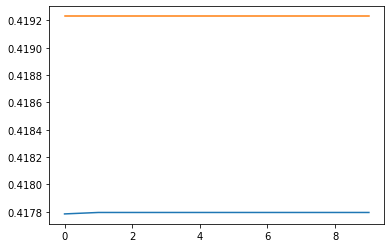

In [102]:
 plt.plot(hist_list[0].history['accuracy'])
plt.plot(hist_list[0].history['val_accuracy'])

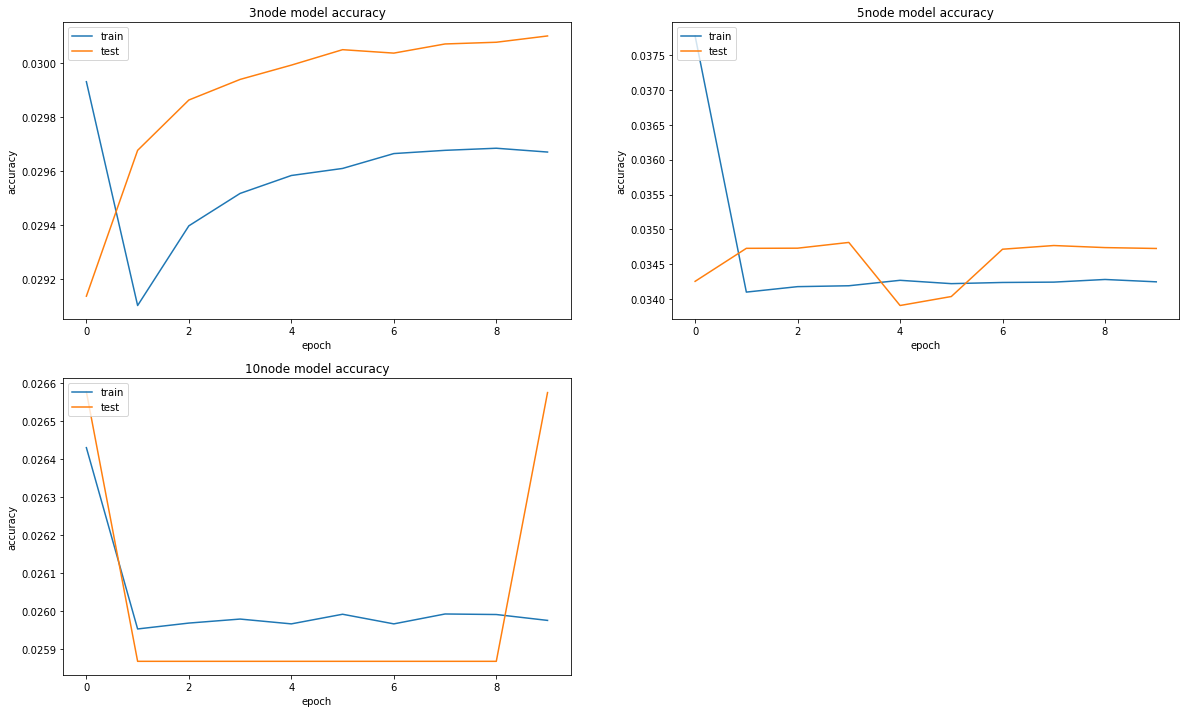

In [37]:
node_list = [3,5,10]
plt.figure(figsize=(20, 12))
for i in range(3):
    plt.subplot(2,2,i+1)    
    plt.plot(hist_list[i].history['accuracy'])
    plt.plot(hist_list[i].history['val_accuracy'])
    plt.title(str(node_list[i])+ 'node model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

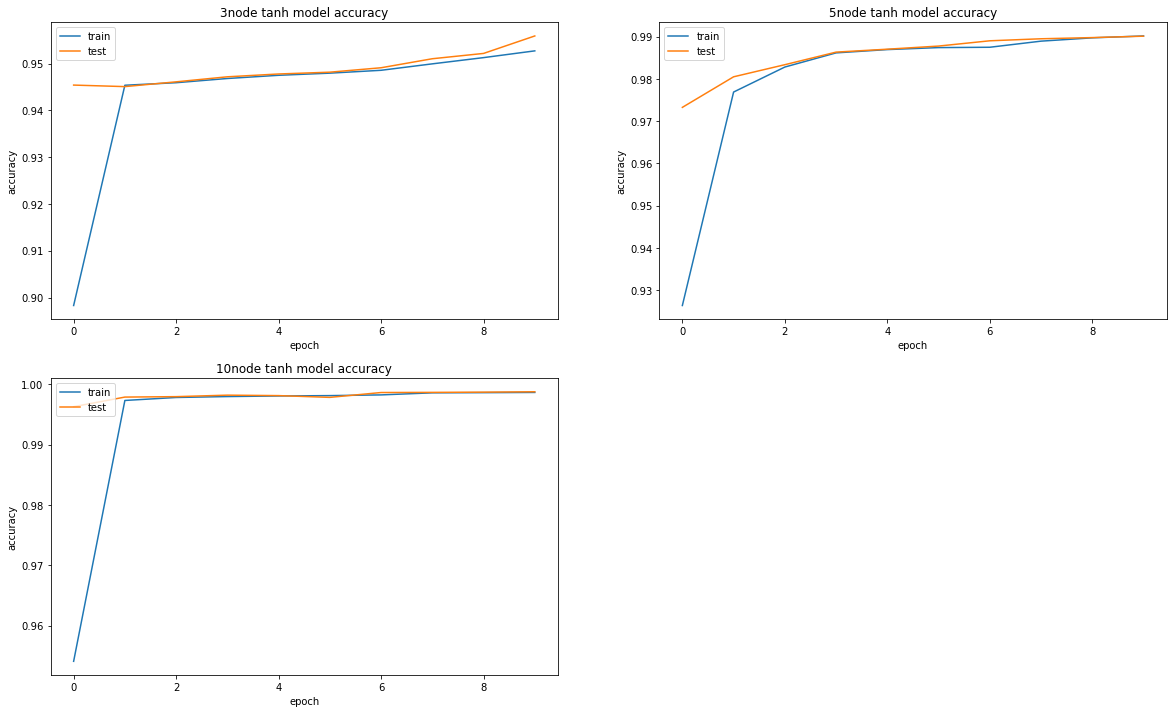

In [106]:
node_list = [3,5,10]
plt.figure(figsize=(20, 12))
for i in range(3):
    plt.subplot(2,2,i+1)    
    plt.plot(tanh_hist[i].history['accuracy'])
    plt.plot(tanh_hist[i].history['val_accuracy'])
    plt.title(str(node_list[i])+ 'node tanh model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

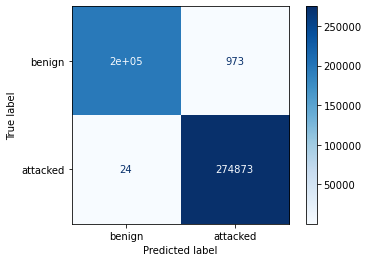

In [195]:
pred = hist_list[0].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

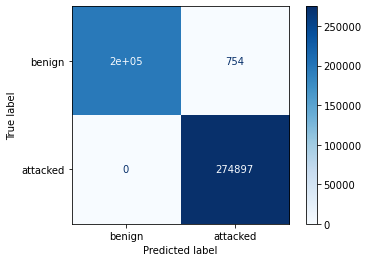

In [196]:
pred = hist_list[1].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

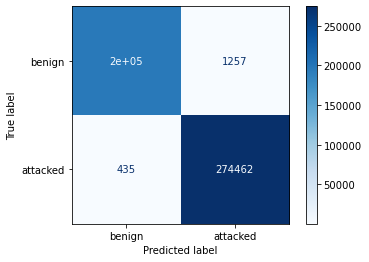

In [197]:
pred = hist_list[2].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

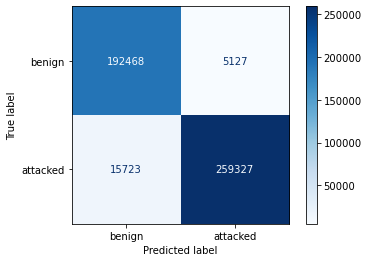

In [113]:
pred = tanh_hist[0].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

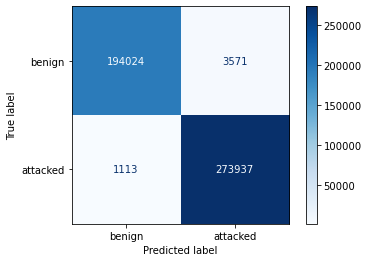

In [114]:
pred = tanh_hist[1].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

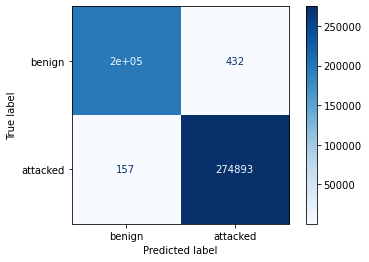

In [115]:
pred = tanh_hist[2].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# 모델 생성 및 저장 부분

In [71]:
def model_test(model_name, params, scaled, ten=False):
    model_list = []
    model_time = []
    if scaled and ten:
        X = X_train_10_scaled
        y = y_train_10
    elif scaled == True:
        X = X_train_scaled
        y = y_train
    elif (scaled == False) and (ten == True):
        X = X_train_10
        y = y_train_10
    else:
        X = X_train
        y = y_train
        
    for i in params:
        start = time.time()
        model_temp = model_name(max_iter=i)
        model_temp.fit(X,y)
        end = time.time()
        model_time.append(end - start)
        model_list.append(model_temp)    
    return (model_list, model_time)

def knn_test(model_name, params):
    model_list = []
    model_time = []
    for i in params:
        start = time.time()
        model_temp = model_name(n_neighbors=i, n_jobs = -1)
        model_temp.fit(X_train_scaled, y_train)
        end = time.time()
        model_time.append(end - start)
        model_list.append(model_temp)    
    return (model_list, model_time)

def knn_test_10(model_name, params):
    model_list = []
    model_time = []
    for i in params:
        start = time.time()
        model_temp = model_name(n_neighbors=i, n_jobs = -1)
        model_temp.fit(X_train_10_scaled, y_train)
        end = time.time()
        model_time.append(end - start)
        model_list.append(model_temp)    
    return (model_list, model_time)

In [72]:
# Logistic_model, Logistic_time = model_test(LogisticRegression, [1000, 3000, 5000], scaled=False, ten=False)
Linear_model, Linear_time = model_test(LinearSVC, [1000, 3000, 5000], scaled=True, ten=False)
print("Linear Done!")
KNN_model, KNN_time = knn_test(KNeighborsClassifier, [3, 5, 10])

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear Done!


In [ ]:
# Logistic_model_10, Logistic_time_10 = model_test(LogisticRegression, [1000, 3000, 5000], scaled=False, ten=True)
# Linear_model_10, Linear_time_10 = model_test(LinearSVC, [1000, 3000, 5000], scaled=True, ten=True)
# KNN_model_10, KNN_time_10 = knn_test_10(KNeighborsClassifier, [3, 5, 10])

모델 새로 저장 원할 시 pkl형식의 모델 리스트 가져와서 새로 저장할것.

In [74]:
def save_model(model):
    joblib.dump(model,str(model[0]).split("(")[0]+".pkl")

In [80]:
KNN_model

[KNeighborsClassifier(n_jobs=-1, n_neighbors=3),
 KNeighborsClassifier(n_jobs=-1),
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)]

In [103]:
save_model(Logistic_model)
save_model(Linear_model)
save_model(KNN_model)

In [60]:
Linear_list.append(Linear_model)

In [62]:
Linear_list[0], Linear_list[2] =Linear_list[2], Linear_list[0]

In [63]:
Linear_list

[[LinearSVC(max_iter=3000)],
 LinearSVC(max_iter=10000),
 LinearSVC(max_iter=5000)]